# TD 8 - 06/02/2024

# Aglind Reka

 



In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from numpy.linalg import norm

## Forward model: blurring and downsampling operator

Let $x\in\mathbb R^{n^2}$ be the ground truth image. The microscope only allows us to have access to a blurred, undersampled and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}, n=Lm,$ is the forward (blurring+undersampling) operator and $\eta\in\mathbb R^{m^2}$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$. $L>0$ is called super-resolution factor: the acquisition $y\in\mathbb R^{m^2}$ lives in a $L^2$ coarser grid than the ground truth $x\in\mathbb R^{n^2}$. 

The forward operator can be modeled as $A=\tilde{M_L}*H$ where 

1) $H:\mathbb R^{n^2} \longrightarrow \mathbb R^{n^2}$ is the blurring operator and can be implemented as a convolution with the PSF 

2) $\tilde{M_L}:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ is the undersampling operator which takes an image in the finer grid and maps it in an image in the coarser grid, averaging the values on $L\times L$ patches of pixels.

 

* Read the ground truth image.

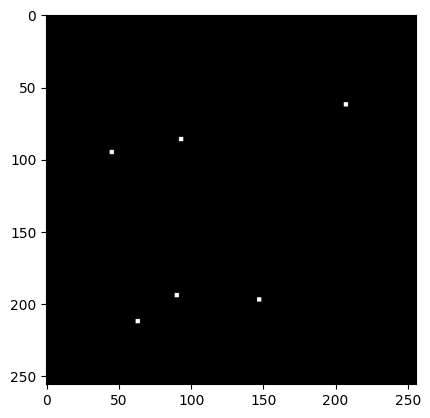

In [2]:
# ground truth image
gt = plt.imread("gt.png")[..., 0]
gt = gt * 255.

# plot the image
plt.imshow(gt, cmap='gray')
plt.show()

Now implement the forward operator. Start with the blurring operator.

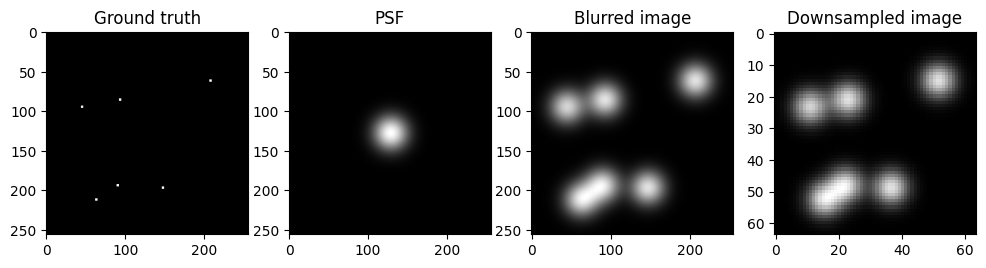

In [3]:
# convolution kernel: the point spread function PSF
def blur_kernel(sig, n):
    t = np.concatenate( (np.arange(0, n/2), np.arange(-n/2, 0)) )
    Y, X = np.meshgrid(t, t)
    h = np.exp((-X**2-Y**2) / (2*sig**2))
    h = h / np.sum(h)
    return h


def blur(x, h):
    return np.real(np.fft.ifft2( np.fft.fft2(h) * np.fft.fft2(x) ))


def downsampling_matrix(n: int, L: int):
    """ returns $M_L$
    """
    m = int(n/L)
    M = np.zeros([m, n])
    for i in np.arange(m):
        M[i, L*i:L*i+L] = 1
    return M


def downsample(x, M):
    return np.dot(M, np.dot(x, M.transpose()))


def forward(x, h, M):
    return downsample(blur(x,h),M)


h = blur_kernel(sig=15, n=gt.shape[0])
blurred_image = blur(gt, h)

# Downsampling
L = 4
M = downsampling_matrix(gt.shape[0], L)
y = forward(gt, h, M)


# Plots
plt.figure(figsize=(12, 4))
plt.subplot(141)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(np.fft.fftshift(h), cmap='gray')
plt.title('PSF')
plt.subplot(143)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.subplot(144)
plt.imshow(y, cmap='gray')
plt.title('Downsampled image')
plt.show()

**NB**: $M_L$ is a $m \times n$ matrix. Formally, $$M_L:\mathbb{R}^{n \times n}\longrightarrow\mathbb{R}^{m \times n}$$ maps $n\times n$ images into $m\times n$ images summing horizantally blocks of $L$ neighbour pixels. 

For $\tilde{M_L}\in\mathbb{R}^{n^2\times m^2}$, we DO NOT go to the Fourier domain! Recalling the computations above and given $M_L\in\mathbb{R}^{n^2\times mn}$, we can see that 
$$\tilde{M_L}z=M_L z M_L^t \qquad \text{(matrix multiplication!)}$$
Altogether, this gives the forward operator: 
$$Ax=M_L H x = M_L(Hx) M_L^t = M_L \cdot real(ifft2(fft2(h)*fft2(x))) \cdot M_L^t$$

Generate gaussian noise and add it to the blurred and downsampled image.

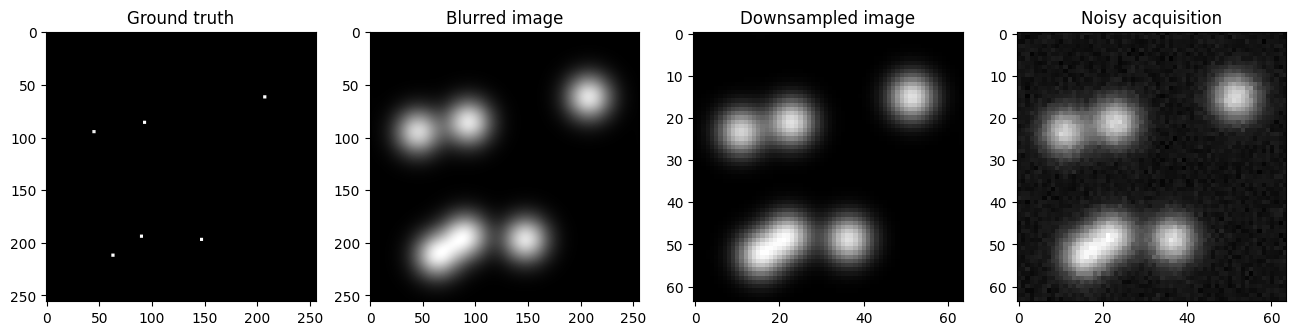

In [4]:
# in this way you will have a deterministic result
np.random.seed(24)
sigma_noise = .7
acq = y + sigma_noise * np.random.randn(*np.shape(y)) 

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred image')
plt.subplot(143)
plt.imshow(y, cmap='gray')
plt.title('Downsampled image')
plt.subplot(144)
plt.imshow(acq, cmap='gray')
plt.title('Noisy acquisition')
plt.show()

## Solving the inverse problem

Let $y\in\mathbb R^{m^2}$ be a noisy acquisition and $A:\mathbb R^{n^2} \longrightarrow \mathbb R^{m^2}$ the forward operator. To solve the inverse problem is to find $x\in\mathbb R^{n^2}$ such that $y\approx Ax$. We use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^{n^2}} \frac{1}{2}\|Ax-y\|_2^2+\lambda R(x) +\texttt{i}_{\ge 0}(x) $$
where $R(x)$ is the regulariser or penalty term. One possible regulariser that promotes sparsity is the $\ell^0$ pseudo-norm defined as 
$$ \|x\|_0 = \#\{i=1,\cdot,n^2|\ x_i\not=0\}=\sum_{i=1}^{n^2} |x_i|_0 \text{ and }|u|_{0}= \begin{cases}0 & \text { if } u=0 \\ 1 & \text { otherwise }\end{cases}$$

## Fidelity term, gradient and Lipschitz costant

Recall: the fidelity term is $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and its gradient is given by $\nabla f(x) = A^t(Ax-y)$. 

Now, the forward operator is $A:\mathbb{R}^{n^2}\longrightarrow\mathbb{R}^{m^2}$ with $A=\tilde{M_L} H$. 
Thus, $A^t=H^t \tilde{M_L}^t$ and 

$$A^t z = H^t \tilde{M_L}^t z = H^t \cdot (M_L^t z M_L) = real(\ ifft2(\ conj(fft2(h))\ *\ fft2(M_L^t z M_L) \ )\ )$$

In [5]:
# fidelity
def fidelity(x, h, M_L, y):
    return 0.5 * np.linalg.norm(forward(x,h,M_L)-y)**2

# define the gradient of the fidelity term in terms of convolutions
def gradient(x, h, M_L, y):
    aus = M_L.T@(forward(x,h,M_L)-y)@M_L
    return np.real(np.fft.ifft2(np.conj(np.fft.fft2(h))* np.fft.fft2(aus)))

# compute the Lipschitz constant Lips
hF = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hF**2)*L**2

## 1) Penalty $\ell_0$ Norm --> Iterative Hard Thresholding Algorithm (IHT)

In [6]:
# cost function
def cost_function_norm0(x, h, M_L, y, lmbda):
    return fidelity(x, h, M_L, y)+lmbda * np.count_nonzero(x)

In [7]:
# proximity operator of the \ell_0 norm
def hard_thresholding(x, tau):
    return x*(x**2>2*tau)
        

In [8]:
# input parameters
# x0 is the initialisation point
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, M_L is the downsampling matrix, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def IHT(x0, tau, lmbda, y, h, M_L, epsilon, maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        if (k + 1) % 100 == 0:
            print(f'Iter {k+1}/{maxiter}')

        # forward step: gradient descent of f
        xkk = xk - tau * gradient(xk, h,M_L, y)

        # backward step
        xkk = hard_thresholding(xkk, tau * lmbda)

        # positivity constraints
        xkk = np.maximum(0, xkk)

        # compute the cost function
        cost[k] = cost_function_norm0(xkk, h,M_L, y, lmbda)
        norms[k] = np.linalg.norm(xkk-xk)

        # update the iteration
        xk = xkk
        if np.abs(cost[k] - cost[k-1]) / cost[k] < epsilon:
            break
    return xk , cost, norms

In [9]:
def plot_results(rec, cost, norms):
    # plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground truth')
    plt.subplot(1, 3, 2)
    plt.imshow(acq, cmap='gray')
    plt.title('Acquisition')
    plt.subplot(1, 3, 3)
    plt.imshow(rec, cmap='gray')
    plt.title('Reconstruction')
    plt.show()

    # plot how the cost function decreases and how the iterates converge
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(cost)
    plt.xlabel('$k$')
    plt.ylabel("$F(x_k)$")
    plt.title('Cost function')
    plt.subplot(1, 2, 2)
    plt.plot(norms)
    plt.xlabel('$k$')
    plt.ylabel("$||x^{(k+1)}-x_{k}||$")
    plt.title('Relative difference in the reconstructions')
    plt.show()

## Play around with different initialisation points 

In [10]:
n = gt.shape[0]
dim= (n,n)
# option 1: zero matrix
x01 = np.zeros(dim)

# option 2: random matrix
x02 = np.random.randn(*dim)

# option 3: upscaled image = \tilde{M_L}^t acq
x03 = M.T @ acq @ M

# option 4: retroprojected image = A^t acq
x04 = np.real(np.fft.ifft2(np.fft.fft2(h)*np.fft.fft2(x03)))

init = [x01, x02, x03, x04]
label = ['Zero matrix', 'Random matrix', 'Upscaled matrix', 'Retroprojection']

Plot the different initialisation points.

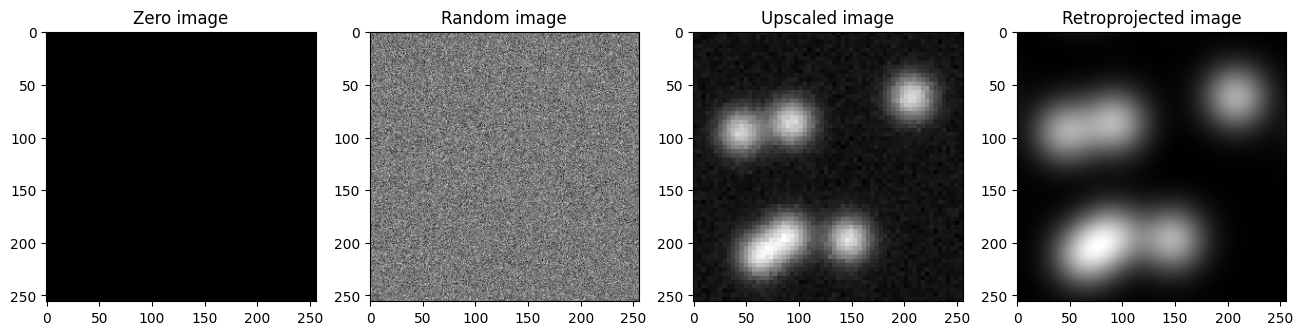

In [11]:
plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(x01, cmap='gray')
plt.title('Zero image')
plt.subplot(142)
plt.imshow(x02, cmap='gray')
plt.title('Random image')
plt.subplot(143)
plt.imshow(x03, cmap='gray')
plt.title('Upscaled image')
plt.subplot(144)
plt.imshow(x04, cmap='gray')
plt.title('Retroprojected image')
plt.show()

Choose an initialisation point and compute the reconstruction. Then change initialisation and see what happens.

Zero matrix
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


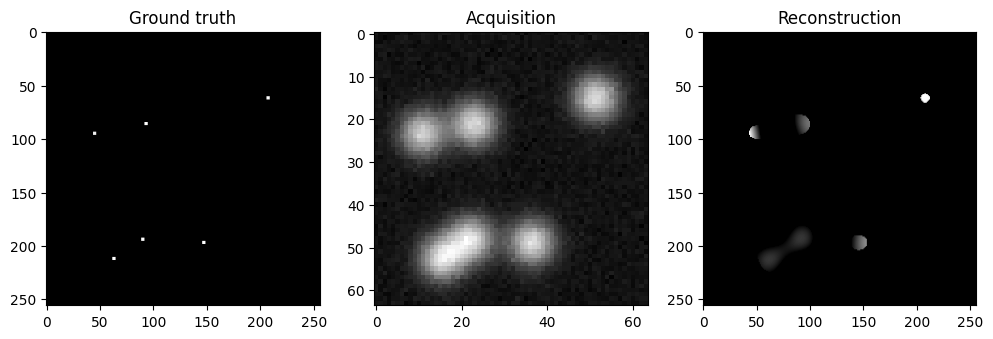

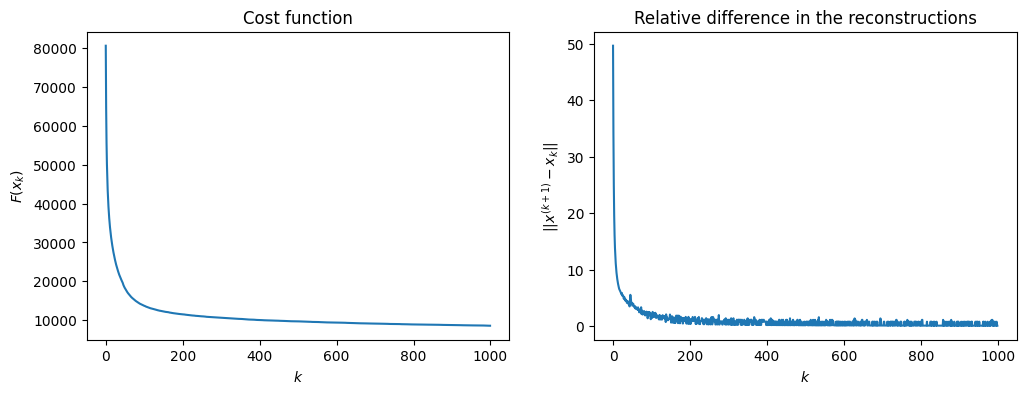

Random matrix
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


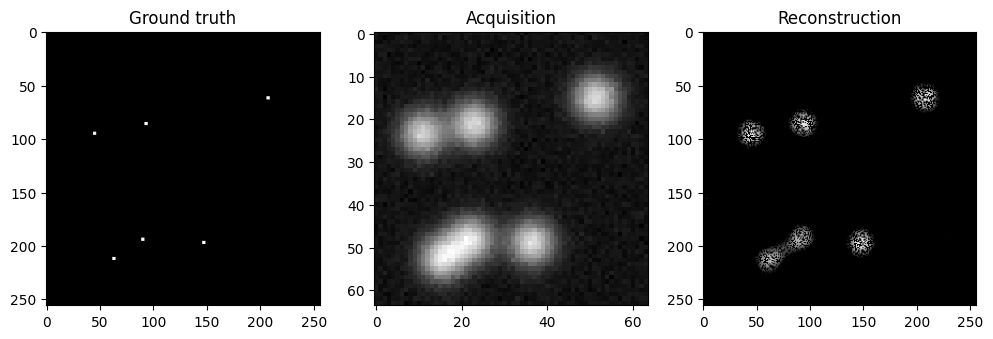

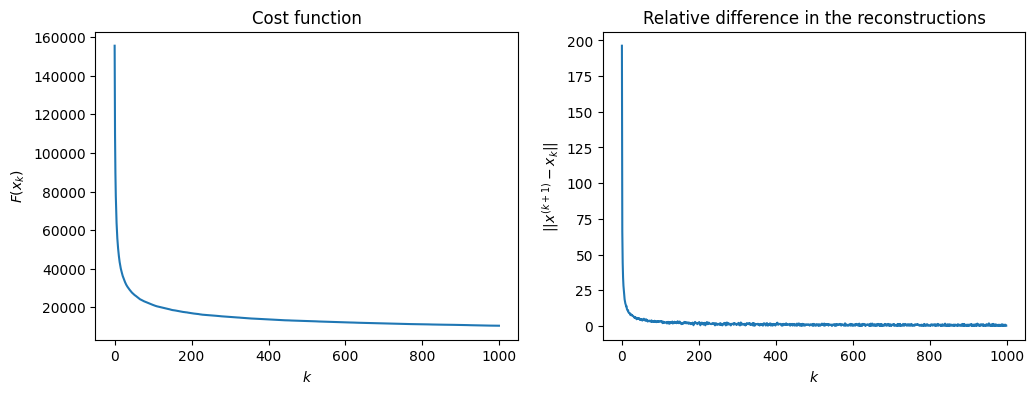

Upscaled matrix
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


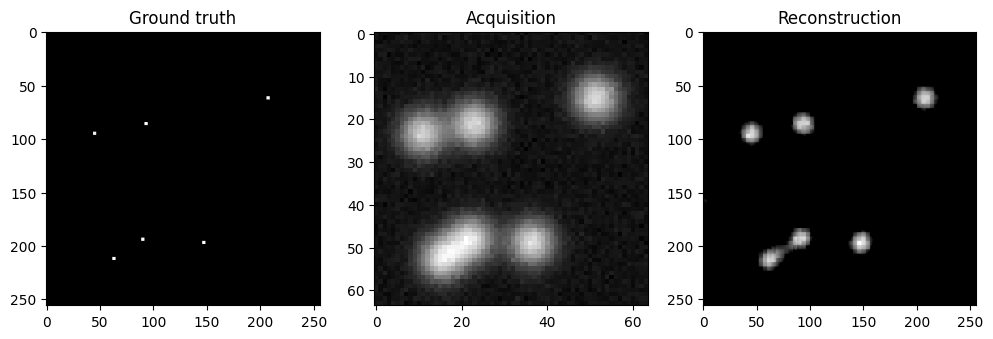

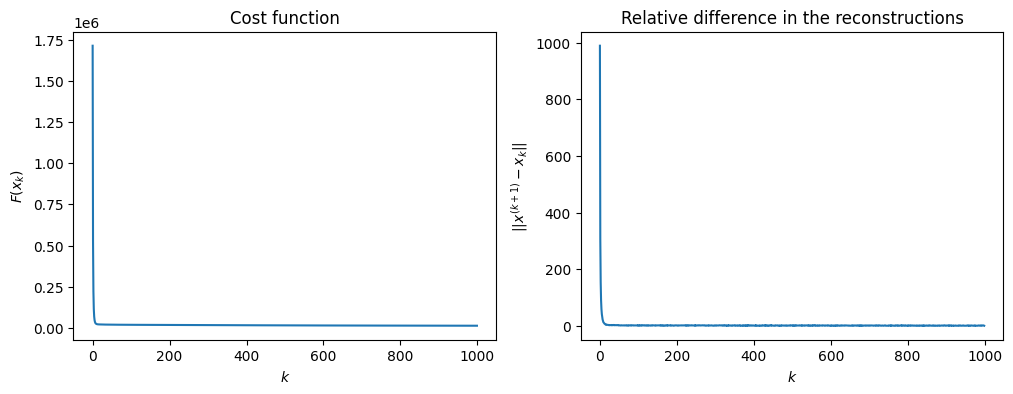

Retroprojection
Iter 100/1000
Iter 200/1000
Iter 300/1000
Iter 400/1000
Iter 500/1000
Iter 600/1000
Iter 700/1000
Iter 800/1000
Iter 900/1000
Iter 1000/1000


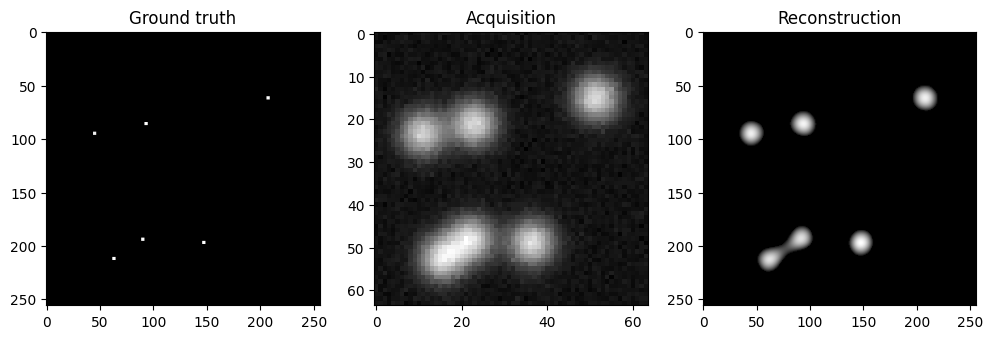

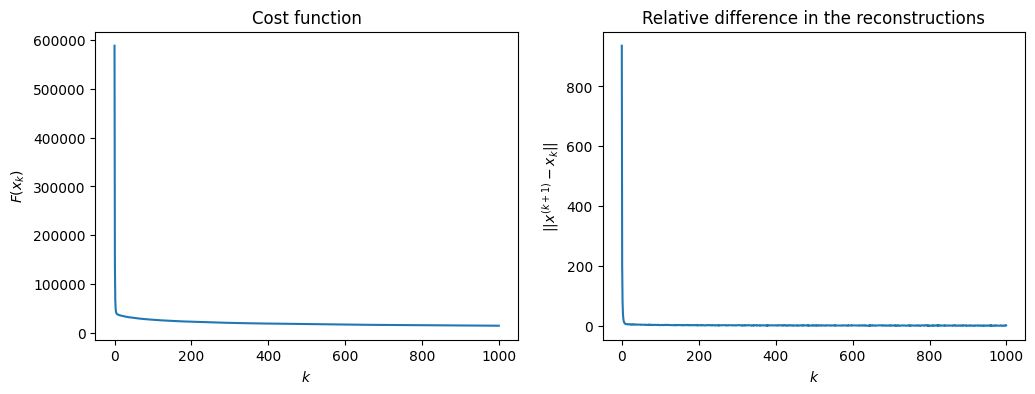

In [12]:
tau = 1 / Lips
lmbda = 5
maxiter = 1000
epsilon = 1e-8

for i in np.arange(np.size(label)):

    x0 = init[i]
    print(label[i])

    # compute the reconstruction
    rec, cost, norms = IHT(x0, tau, lmbda, acq, h, M, epsilon, maxiter)
    plot_results(rec, cost, norms)

Observe that the reconstruction changes with respect to different choices of the initialisation point! This behaviour is typical when minimizing non-convex functions. 

## Relaxations to the $\ell_0$ pseudo-norm


1) $\ell_1$ norm 
$$\|x\|_1=\sum_{i=1}^{n^2} |x_i|$$

2) $\ell_p$ with $0<p<1$ 
$$\|x\|_p=\Big(\sum_{i=1}^{n^2} |x_i|^p\Big)^{1/p}$$

3) CEL0 penalty with $a>0$ and $\lambda>0$
$$\phi_{CEL0}(x,\lambda,a)=\lambda-\frac{a^{2}}{2}\left(|x|-\frac{\sqrt{2 \lambda}}{a}\right)^{2} \mathbb{1}_{\left\{|x| \leqslant \frac{\sqrt{2 \lambda}}{a}\right\}}, \lambda>0, a>0$$


Define the above penalties as functions which take as input arrays and return arrays, computing the value of the penalties componentwise.

In [13]:
def norm0(x):
    return (x!=0)

def norm1(x):
    return np.abs(x)

def normP(x, p):
    return (np.abs(x)**p)

def CEL0(x, lambd, a):
    return lambd - 0.5 * a**2 * (np.abs(x) - np.sqrt(2 * lambd) / a) ** 2 * (np.abs(x) <= np.sqrt(2 * lambd) / a)

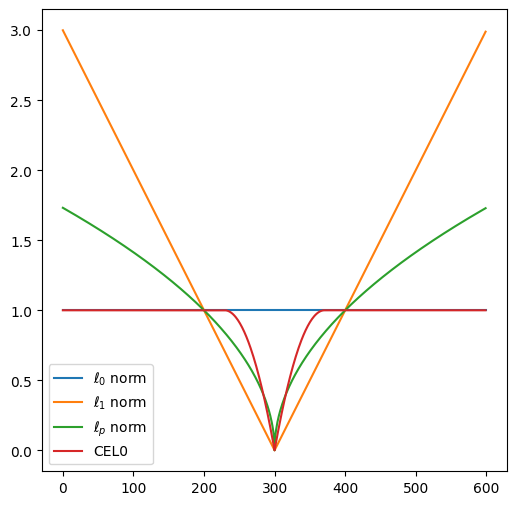

In [14]:
#plot the different penalties on the interval [-3,3]
x = np.arange(-3, 3, 0.01)

plt.figure(figsize=(6, 6))
plt.plot(norm0(x), label='$\ell_0$ norm') # \ell_0 norm
plt.plot(norm1(x), label='$\ell_1$ norm') # \ell_1 norm
plt.plot(normP(x, 0.5), label='$\ell_p$ norm') # \ell_p norm with p=0.5
plt.plot(CEL0(x, 1, 2), label='CEL0') # cel0
plt.legend(loc='best')
plt.show()

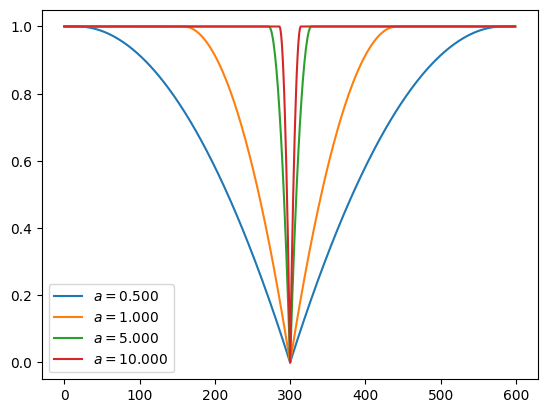

In [15]:
# plot CEL0 penalty for different values of the parameter a
lambd = 1
a = [0.5, 1, 5, 10]
plt.figure()
for i in np.arange(np.size(a)):
    plt.plot(CEL0(x, lambd, a[i]), label=r'$a=%.3f$' % a[i])
    plt.legend(loc='best')
plt.show()

## 2) Penalty $\ell_1$ Norm --> Iterative Soft Thresholding Algorithm (ISTA)

In [16]:
# cost function
def cost_function_norm1(x, h, M_L, y, lmbda):
    return fidelity(x, h, M_L, y)+lmbda*np.linalg.norm(x,1)

In [17]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
    return np.sign(x)*np.maximum(0, np.abs(x)-gamma)

In [18]:
# input parameters
# x0 is the initialisation point
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, M_L is the downsampling matrix, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def ISTA(x0, tau, lmbda, y, h, M_L, epsilon, maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # forward step: gradient descent of f
        xkk = xk - tau*gradient(xk, h, M_L, y)
        # backward step
        xkk = soft_thresholding(xkk, tau*lmbda)
        # positivity constraints
        xkk = np.maximum(0,xkk)
        # compute the cost function
        cost[k] = cost_function_norm1(xkk, h, M_L, y, lmbda)
        norms[k] = np.linalg.norm(xkk-xk)
        # update the iteration
        xk = xkk
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

Choose an initialisation point and compute the reconstruction. Change it and see what happens to the reconstruction.

Zero matrix


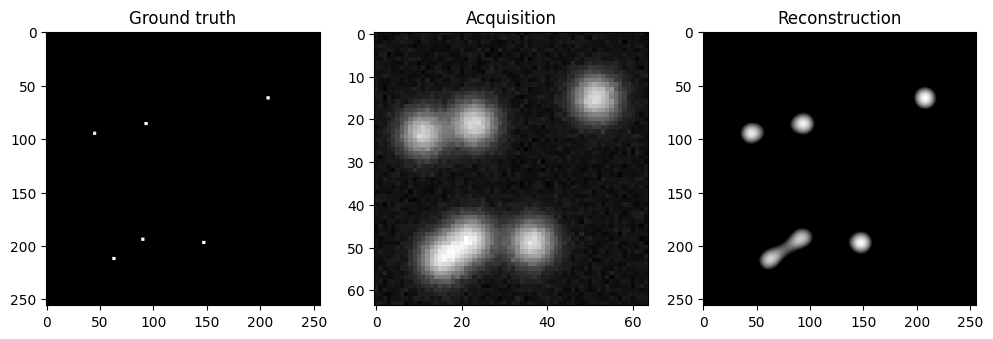

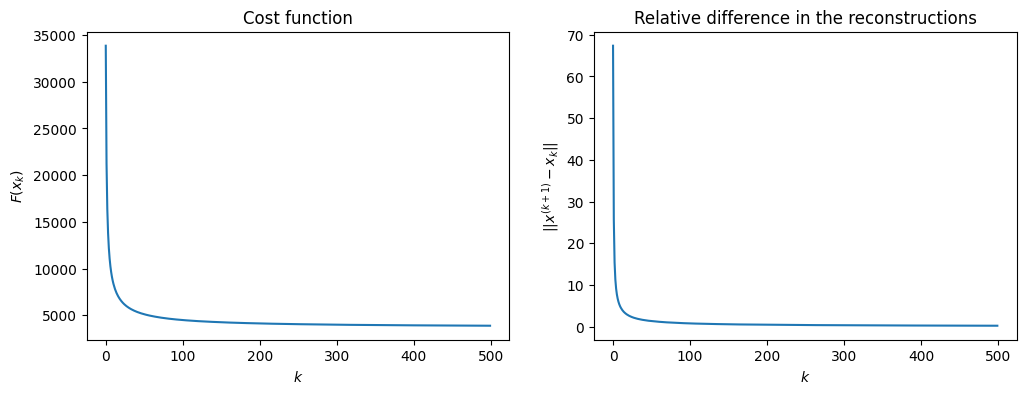

Random matrix


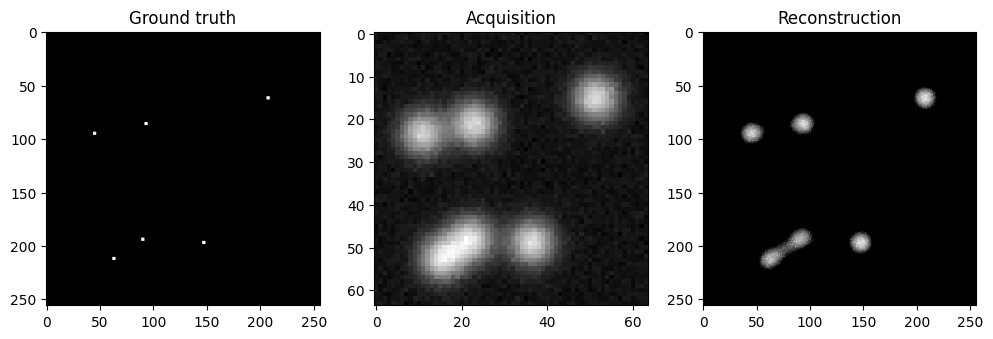

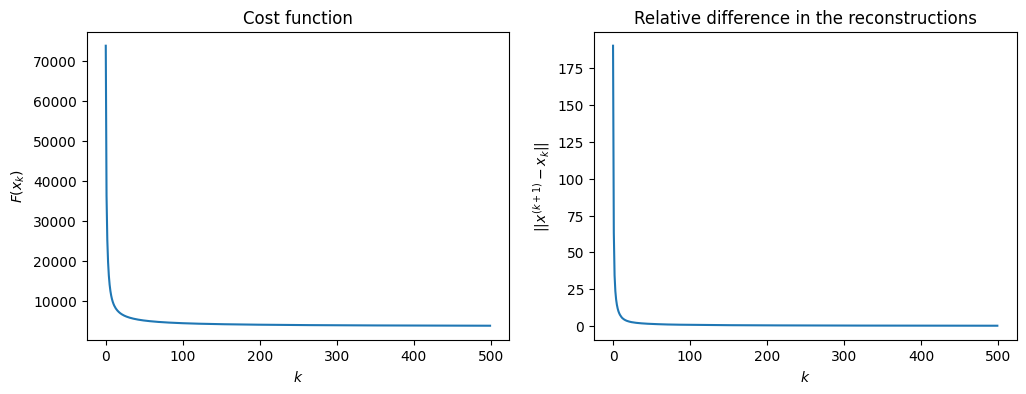

Upscaled matrix


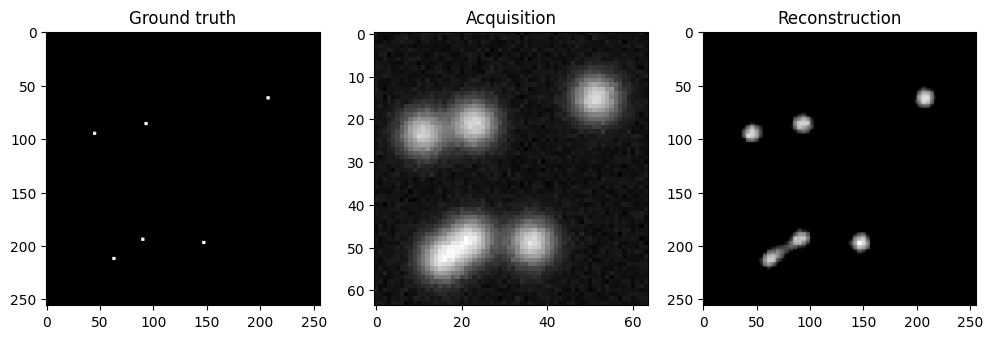

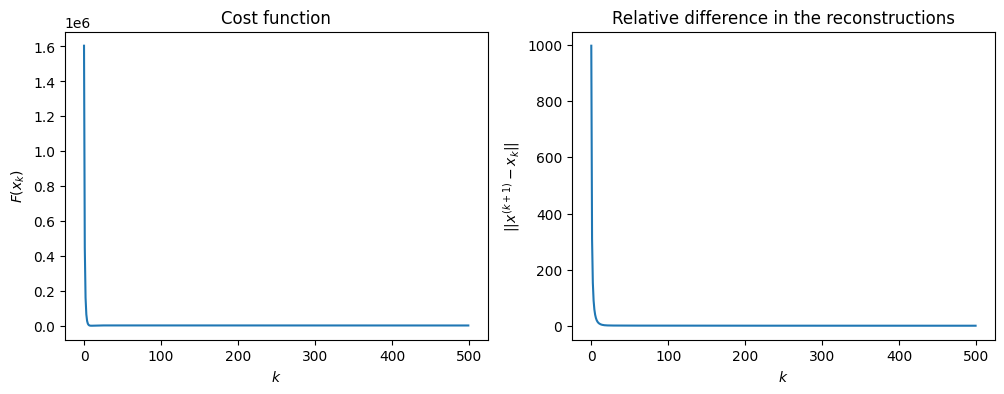

Retroprojection


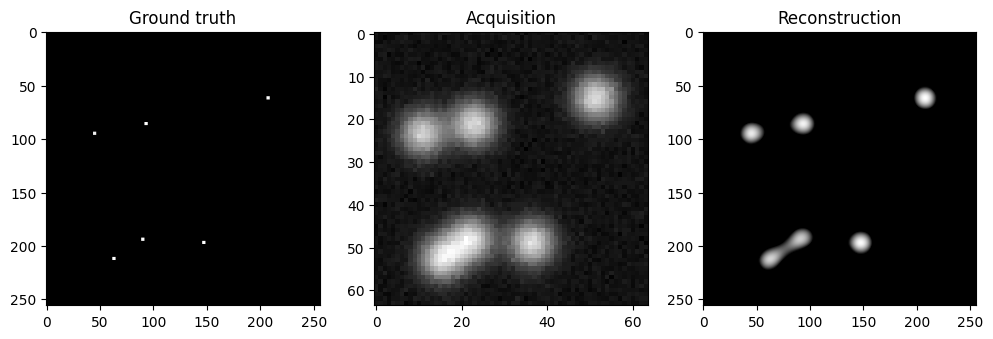

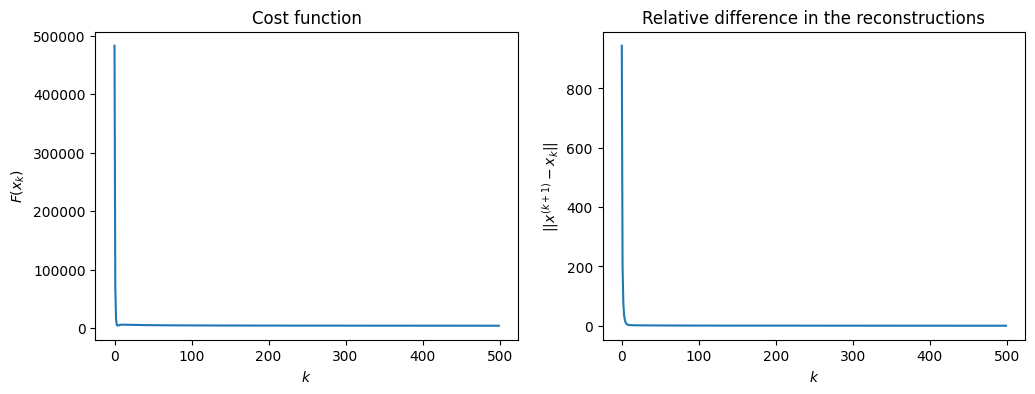

In [19]:
tau = 1/Lips
lmbda = 2
maxiter = 500
epsilon = 1e-8

for i in np.arange(np.size(label)):

    x0 = init[i]
    print(label[i])

    # compute the reconstruction
    rec, cost, norms = ISTA(x0, tau, lmbda, acq, h, M, epsilon, maxiter)
    plot_results(rec, cost, norms)

Observe that now the reconstruction is not affected by the coice of the initialisation point.

## Proximal operators of non-convex functions

Go to http://proximity-operator.net/nonconvexfunctions.html 

You can find the analytical expression, matlab and python codes.

## 3) CEL0 penalty --> Forward-Backward Splitting algorithm

$$\Phi_{CEL0}(x,\lambda,A):=\sum_{i=1}^{n^2}\phi(||a_i||_2,\lambda,x_i)=\sum_{i=1}^{n^2} \lambda -\frac{||a_i||_2^2}{2}\left(|x_i|-\frac{\sqrt{2\lambda}}{||a_i||_2}\right)^2 \delta_{\{|x_i|<\frac{\sqrt{2\lambda}}{||a_i||_2} \}}$$

Compute the values of $\|a_i\|_2^2$ for $i=1,\cdots,n^2$. Note that $a_i\in\mathbb R^{m^2}$, where $m=n/L$. 

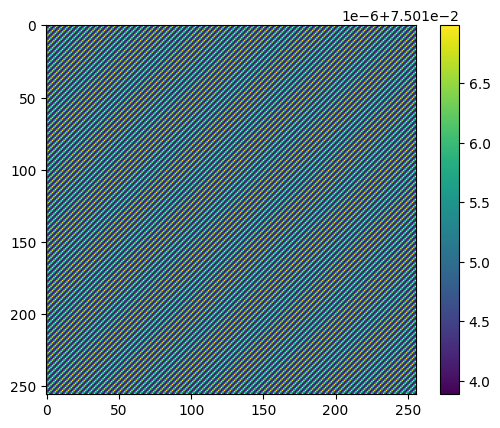

In [20]:
m = int(n/L)
normai = np.zeros([L,L])
for i in np.arange(L):
    for j in np.arange(L):
        matr = M @ np.transpose(np.roll(h, [j,i])) @ np.transpose(M)
        normai[i, j] = np.linalg.norm(matr)
normai = repmat(normai, m, m)

plt.figure()
plt.imshow(normai)
plt.colorbar()
plt.show()

In [21]:
# cost function
def cost_function_CEL0(x, h, M_L, y, lmbda, normai):
    return np.linalg.norm(y - forward(x, h, M_L)) ** 2 + lmbda * np.sum(CEL0(x, lmbda, normai))

The proximal operator of the 1-dimensional $\phi_{CEL0}(\cdot,\lambda,a)$ is given by:
$$ \operatorname{prox}_{\gamma \phi_{CEL0}(\cdot,\lambda,a)}(x)=\begin{cases}\operatorname{sign}(x) \min \left\{|x|, \frac{\max \{|x|-\sqrt{2 \lambda} \gamma a, 0\}}{1-a^{2} \gamma}\right\} & \text { if } a^{2} \gamma<1 \\ x 1_{\{|x|>\sqrt{2 \gamma \lambda}\}}+\{0, x\} 1_{\{|x|=\sqrt{2 \gamma \lambda}\}} & \text { if } a^{2} \gamma \geqslant 1\end{cases}$$

In practice, only the case $a^{2} \gamma<1$ is needed.

In [22]:
 def prox_CEL0(x, gamma, lambd, a):
        
        abs_x = np.abs(x)
        sign_x = np.sign(x)

        # 1st case:  a**2*gamma >=1
        mask1 = abs_x > np.sqrt(2 * gamma * lambd)
        prox_ = 1.0 * x * mask1

        if np.size(a**2 * gamma) <= 1 and (a**2 * gamma >= 1):
            return np.reshape(prox_, np.shape(x))

        # 2nd case: a**2*gamma < 1
        mask = a**2 * gamma < 1
        if np.size(lambd) > 1:
            lambd = lambd[mask]
        if np.size(a) > 1:
            a = a[mask]
        if np.size(gamma) > 1:
            gamma = gamma[mask]

        p2 = np.maximum(abs_x[mask] - np.sqrt(2 * lambd) * gamma * a, 0) / (
            1 - a**2 * gamma
        )
        prox_[mask] = sign_x[mask] * np.minimum(abs_x[mask], p2)
        return prox_

In [23]:
# input parameters
# x0 is the initialisation point
# tau is the stepsize
# lambda is the regolarisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion

def FB_CEL0(x0,tau,lmbda,y,h,M_L,normai,epsilon,maxiter):
    xk = x0
    cost = np.zeros(maxiter)
    norms = np.zeros(maxiter)
    for k in np.arange(maxiter):
        # forward step: gradient descent of f
        xkk = xk - tau * gradient(xk, h, M_L, y)

        # backward step
        xkk = prox_CEL0(xkk, lambd*tau, lambd, normai)

        # positivity constraints
        xkk = np.maximum(0, xkk)

        # compute the cost function
        cost[k] = cost_function_CEL0(xkk,h,M_L,y,lmbda,normai)
        norms[k] = np.linalg.norm(xkk-xk)

        # update the iteration
        xk = xkk
        if np.abs(cost[k]-cost[k-1])/cost[k]<epsilon:
            break
    return xk , cost, norms

Choose an initialisation point and compute the reconstruction. Change it and see what happens to the reconstruction.

Zero matrix


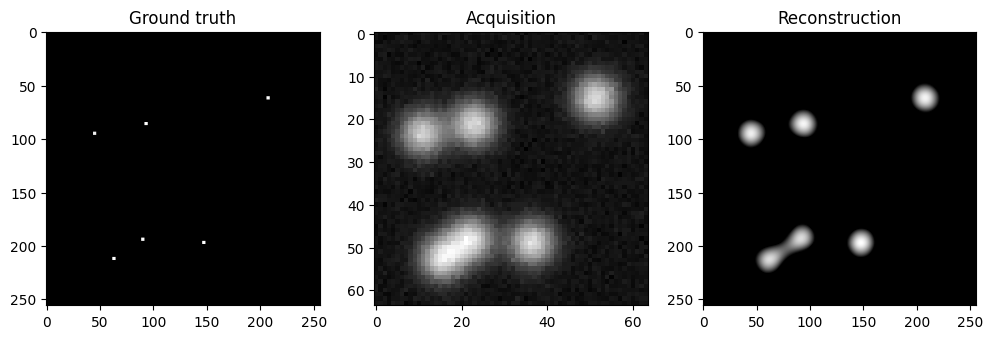

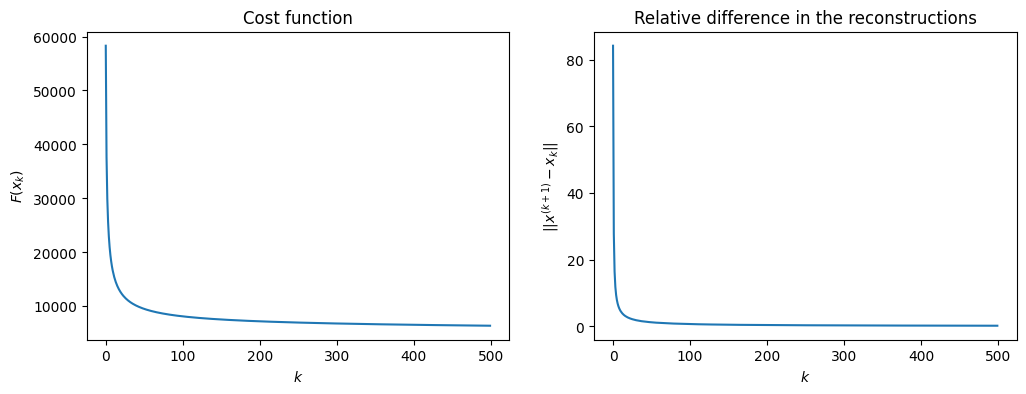

Random matrix


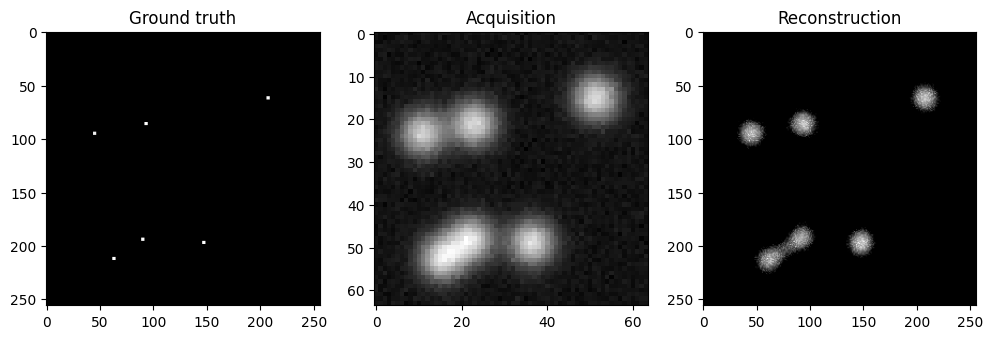

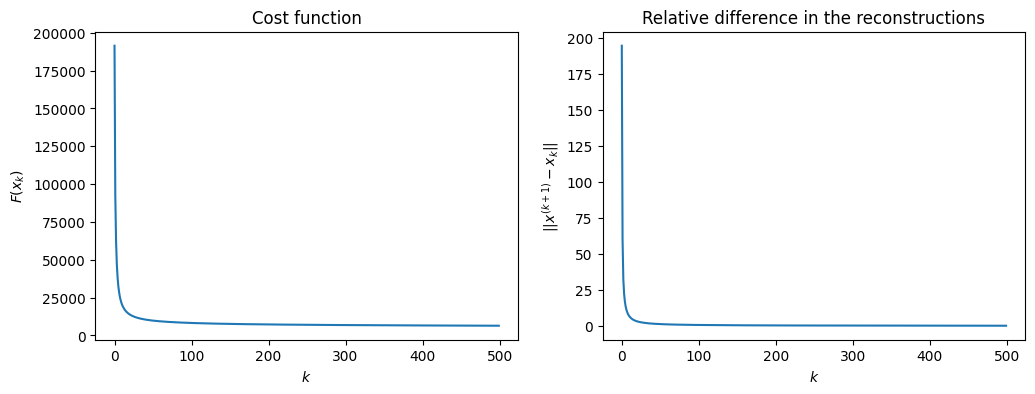

Upscaled matrix


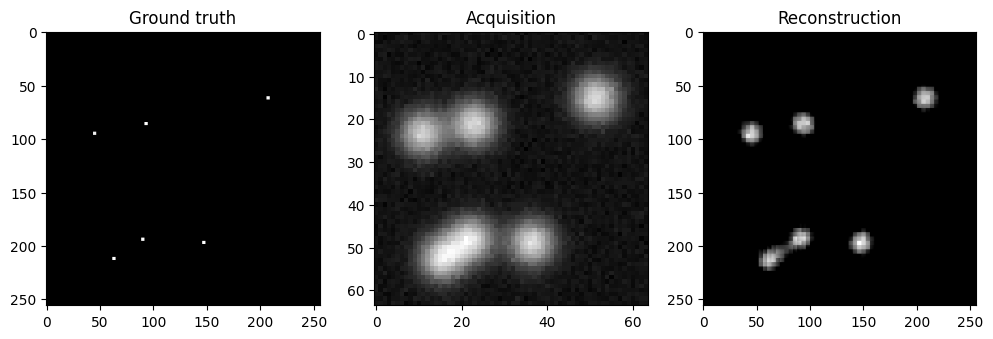

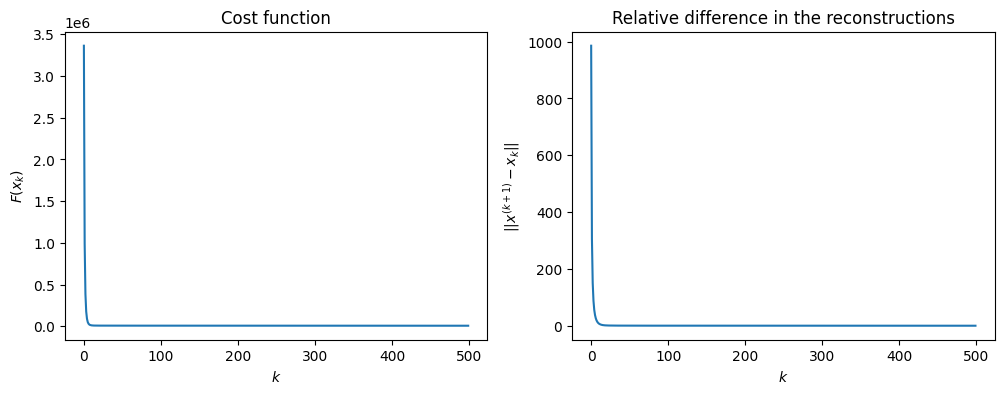

Retroprojection


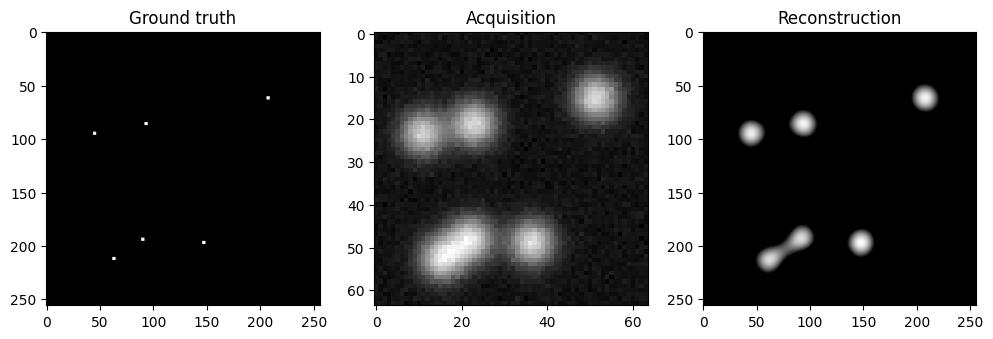

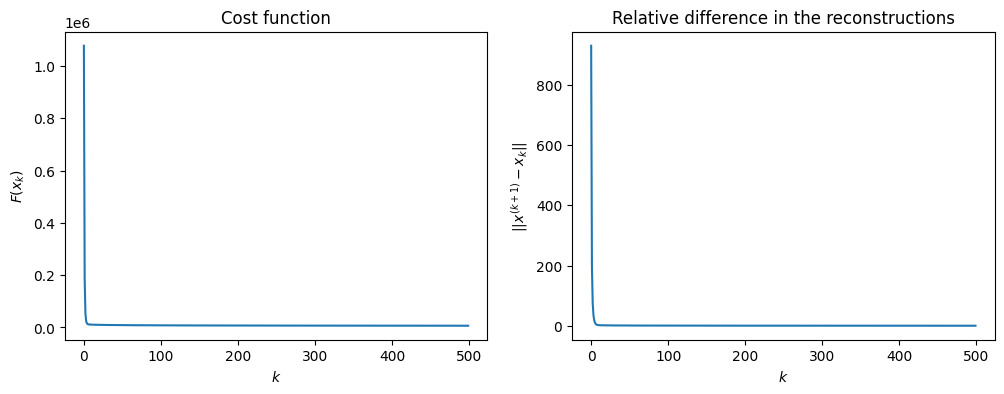

In [24]:
tau = 1/Lips
lmbda = 2
maxiter = 500
epsilon = 1e-8

for i in np.arange(np.size(label)):

    x0 = init[i]
    print(label[i])

    # compute the reconstruction
    rec, cost, norms = FB_CEL0(x0, tau, lmbda, acq, h, M, normai, epsilon, maxiter)
    plot_results(rec, cost, norms)

* Is the reconstruction affected by the choice of the initialisation?

Like I see above, the initialisation point in the reconstuction has no affect (as mentioned in L1 norm result). 